In [1]:
cd /workspace/fast-influence-functions/

/workspace/fast-influence-functions


In [2]:
from experiments.mnli import *
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
task_tokenizer, task_model = misc_utils.create_tokenizer_and_model(
    constants.MNLI_MODEL_PATH)

imitator_tokenizer, imitator_model = misc_utils.create_tokenizer_and_model(
    constants.MNLI_IMITATOR_MODEL_PATH)

(mnli_train_dataset,
 mnli_eval_dataset) = misc_utils.create_datasets(
    task_name="mnli",
    tokenizer=task_tokenizer)

task_model.cuda()
imitator_model.cuda()
if task_model.training is True or imitator_model.training is True:
    raise ValueError("One of the model is in training mode")
print(task_model.device, imitator_model.device)

# Most of these arguments are placeholders
# and are not really used at all, so ignore
# the exact values of these.
trainer = transformers.Trainer(
    model=task_model,
    args=TrainingArguments(
        output_dir="./tmp-output",
        per_device_train_batch_size=128,
        per_device_eval_batch_size=128,
        learning_rate=5e-5,
        logging_steps=100),
)

Params Trainable: 14768643
	bert.encoder.layer.10.attention.self.query.weight
	bert.encoder.layer.10.attention.self.query.bias
	bert.encoder.layer.10.attention.self.key.weight
	bert.encoder.layer.10.attention.self.key.bias
	bert.encoder.layer.10.attention.self.value.weight
	bert.encoder.layer.10.attention.self.value.bias
	bert.encoder.layer.10.attention.output.dense.weight
	bert.encoder.layer.10.attention.output.dense.bias
	bert.encoder.layer.10.attention.output.LayerNorm.weight
	bert.encoder.layer.10.attention.output.LayerNorm.bias
	bert.encoder.layer.10.intermediate.dense.weight
	bert.encoder.layer.10.intermediate.dense.bias
	bert.encoder.layer.10.output.dense.weight
	bert.encoder.layer.10.output.dense.bias
	bert.encoder.layer.10.output.LayerNorm.weight
	bert.encoder.layer.10.output.LayerNorm.bias
	bert.encoder.layer.11.attention.self.query.weight
	bert.encoder.layer.11.attention.self.query.bias
	bert.encoder.layer.11.attention.self.key.weight
	bert.encoder.layer.11.attention.self.ke

You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


cuda:0 cuda:0


In [4]:
# torch.save(outputs_collections, "/export/home/Experiments/20200722/outputs_collections.0-5.right.generated-label.pt")

# outputs_collections_0_4 = torch.load("/export/home/Experiments/20200722/outputs_collections.0-5.wrong.ground-truth-label.pt")
# outputs_collections_5_9 = torch.load("/export/home/Experiments/20200722/outputs_collections.6-10.wrong.ground-truth-label.pt")
# outputs_collections_0_4 = torch.load("/export/home/Experiments/20200722/outputs_collections.0-5.wrong.generated-label.pt")
# outputs_collections_5_9 = torch.load("/export/home/Experiments/20200722/outputs_collections.6-10.wrong.generated-label.pt")
# outputs_collections_0_4 = torch.load("/export/home/Experiments/20200722/outputs_collections.0-5.right.ground-truth-label.pt")
# outputs_collections_5_9 = torch.load("/export/home/Experiments/20200722/outputs_collections.0-5.right.generated-label.pt")
outputs_collections_correct = torch.load("/export/home/hguo/Experiments/20201119/imiator_experiments.only-correct.10.pt")
outputs_collections_incorrect = torch.load("/export/home/hguo/Experiments/20201119/imiator_experiments.only-incorrect.10.pt")

In [5]:
from tqdm import tqdm

In [6]:
original_imitator_loss = {}

for collection in tqdm(outputs_collections_correct + outputs_collections_incorrect):
    # duplicate, skip one of them
    if collection["finetune_using_ground_truth_label"] is False:
        continue

    _, _, imitator_loss = misc_utils.predict(
        trainer=trainer,
        model=imitator_model,
        inputs=collection["imitator_test_inputs"])

    if collection["index"] in original_imitator_loss.keys():
        raise ValueError
    original_imitator_loss[collection["index"]] = imitator_loss

100%|██████████| 40/40 [00:00<00:00, 55.71it/s]


In [7]:
outputs_collections_correct_subset = [
    collection for collection in outputs_collections_correct
    if collection["finetune_using_ground_truth_label"] is True]

outputs_collections_incorrect_subset = [
    collection for collection in outputs_collections_incorrect
    if collection["finetune_using_ground_truth_label"] is True]

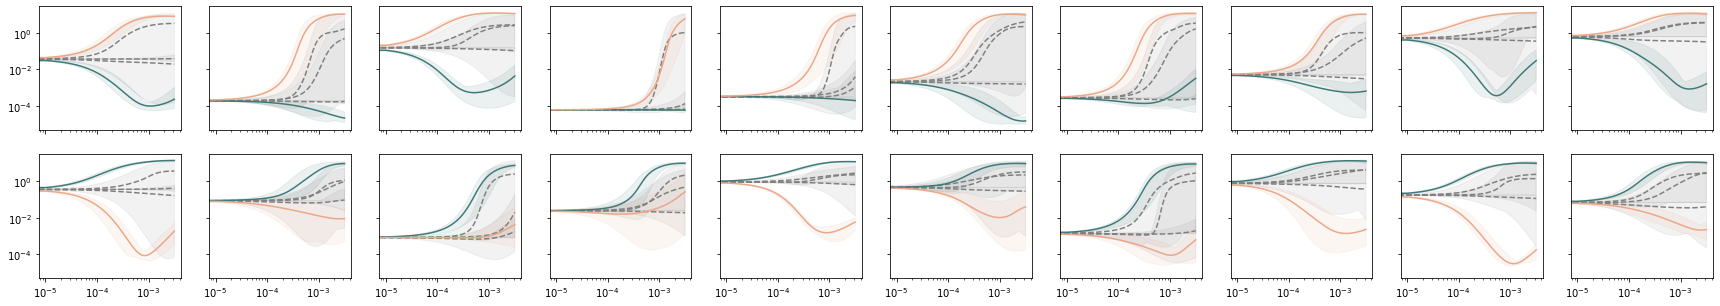

In [9]:
# plt.rcParams["figure.figsize"] = (30, 5)
# figure, axes = plt.subplots(2, 10, sharex=True, sharey=True)
# for index in range(len(outputs_collections_correct_subset)):
#     collection = outputs_collections_correct_subset[index]
#     _plot_Xs_and_Ys_dict(
#         axis=axes[0, index],
#         fontsize=20,
#         title="Right Prediction (GT)",
#         Xs=[0.0] + np.logspace(-5, -2.5, 50).tolist(),
#         Ys_dict=collection["losses"],
#         baseline=original_imitator_loss[collection["index"]]
#     )

# for index in range(len(outputs_collections_incorrect_subset)):
#     collection = outputs_collections_incorrect_subset[index]
#     _plot_Xs_and_Ys_dict(
#         axis=axes[1, index],
#         fontsize=20,
#         title="Right Prediction (Generated)",
#         Xs=[0.0] + np.logspace(-5, -2.5, 50).tolist(),
#         Ys_dict=collection["losses"],
#         baseline=original_imitator_loss[collection["index"]]
#     )


# # axes[-1, -1].legend()
# # figure.savefig("./20201120-imitator-0-10.fine-tune-using-gt.pdf")

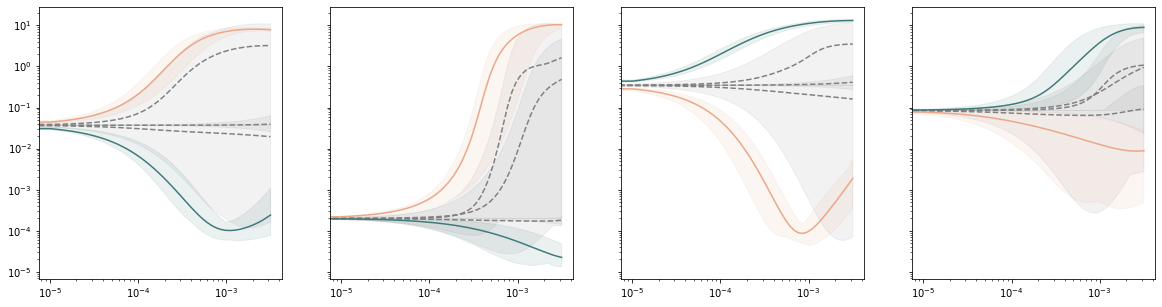

In [22]:
plt.rcParams["figure.figsize"] = (20, 5)
figure, axes = plt.subplots(1, 4, sharex=True, sharey=True)
for index in range(2):
    collection = outputs_collections_correct_subset[index]
    _plot_Xs_and_Ys_dict(
        axis=axes[index],
        fontsize=20,
        title="Right Prediction (GT)",
        Xs=[0.0] + np.logspace(-5, -2.5, 50).tolist(),
        Ys_dict=collection["losses"],
        baseline=original_imitator_loss[collection["index"]]
    )

for index in range(2):
    collection = outputs_collections_incorrect_subset[index]
    _plot_Xs_and_Ys_dict(
        axis=axes[index + 2],
        fontsize=20,
        title="Right Prediction (Generated)",
        Xs=[0.0] + np.logspace(-5, -2.5, 50).tolist(),
        Ys_dict=collection["losses"],
        baseline=original_imitator_loss[collection["index"]]
    )


# axes[-1, -1].legend()
figure.savefig("./20201120-imitator-0-2.flattened.fine-tune-using-gt.pdf")

In [8]:
def _plot_Xs_and_Ys_dict(
        axis,
        title: str,
        fontsize: int,
        Xs: List[float],
        Ys_dict: Dict[str, List[List[float]]],
        baseline: float,
) -> None:
    # plt.rcParams["figure.figsize"] = (10, 10)
    color_map = {
        "random-neutral": "grey",
        "random-entailment": "grey",
        "random-contradiction": "grey",
        "most-positive-influential": "#EBA788",
        "most-negative-influential": "#407A78",}

    legends = []
    for tag in Ys_dict.keys():
        if tag not in color_map.keys():
            raise ValueError

        legends.append(tag)
        color = color_map[tag]
        data = np.array(Ys_dict[tag])
        is_random_data_point = "random" in tag

        if data.shape[0] != 1:
            data_mean = [baseline] + data.mean(axis=0).tolist()
            data_std = [0.0] + data.std(axis=0).tolist()
            data_upper = [baseline] + data.max(axis=0).tolist()
            data_lower = [baseline] + data.min(axis=0).tolist()
            # data_upper = [(m + s) for m, s in zip(data_mean, data_std)]
            # data_lower = [(m - s) for m, s in zip(data_mean, data_std)]
            axis.plot(
                Xs,
                data_mean,
                color=color,
                linestyle=("--" if is_random_data_point else None),
                label=f"{tag} (mean)")

            axis.fill_between(
                Xs,
                data_upper,
                data_lower,
                alpha=0.1,
                color=color,
                label=f"{tag} (min/max)"
            )
        else:
            raise ValueError

    axis.set_xscale("log")
    axis.set_yscale("log")